In [97]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import cf
# import cfplot as cfp
import xclim
import pandas as pd
import netCDF4

from nc_processing import *
from analysis import * 

%matplotlib inline

# Let's calculate some efficacy metric stuff for precipitation


In [119]:
"""
Specify the common inputs
"""
data_dir='/home/users/pjirvine/data/' # !!!!!!!!!!!!! CHANGE THIS !!!!!!!!!!!!!!!!!!

model='UKESM1-0-LL'
centre='MOHC'

grid='gn'
time_files=1

season='ANN'

# specify a list of runs
runs=['r1i1p1f2','r4i1p1f2','r8i1p1f2']

# the t-test needs to know how long our sample is.
num_years = 90 
p_thresh = 0.05 # for 95% T-Test

"""
Now I create some dictionaries to group together terms, i.e. variables with their "domains", and experiments with their project and time-average period.
"""
var_settings_dict = {'pr':'Amon',
                     'tas':'Amon', # the final ',' isn't needed but it allows you to add items to this dict later without issues.
                     'sfcWind':'Amon',
                     'psl':'Amon',
                    }

# for the experiments there are 2 variables to store: the project and the date range used for averaging. I bundle these into one value using the regular brackets ().
exp_settings_dict = {'historical':('CMIP',['1960-01-01','1989-12-30']),
                     'ssp245':('ScenarioMIP',['2070-01-01','2099-12-30']),
                     'ssp585':('ScenarioMIP',['2070-01-01','2099-12-30']),
                     'G6solar':('GeoMIP',['2070-01-01','2099-12-30']),
                     'G6sulfur':('GeoMIP',['2070-01-01','2099-12-30']),
                    }

# Now, I'm going to wrap the code which got all the means and standard deviations in the full_figure_example into a loop that enters the data into a dictionary. 

In [120]:
# Create an empty dictionary to store the data
data_dict = {}

# Loop over all variables, catching the "domain" value stored in the var_settings_dict
for var, domain in var_settings_dict.items():
    
    # Loop over all experiments, catching the settings stored in exp_settings_dict
    for exp, exp_settings in exp_settings_dict.items():
    
        # Now I unpack the 2 values stored in exp_settings into two variables
        project, dates = exp_settings
        
        # get the mean and standard deviation using get_ens_seasonal_mean_std()
        # all the inputs needed for the function have been specified above except for:
        # VAR and DOMAIN which are specified by the outer for loop, and
        # EXP, PROJECT and DATES which are specified by the inner for loop
        ds_mean, ds_std = get_ens_seasonal_mean_std(season, dates, data_dir, model, centre, var, domain, exp, project, runs, grid, time_files=time_files)
        
        # Here the "key" for the dictionary has 3 parts: var, exp, and then 'mean' or 'std'
        data_dict[var, exp, 'mean'] = ds_mean[var]
        data_dict[var, exp, 'std'] = ds_std[var]
        
    # end for exp
    
#end for exp

"""
Now we have a dictionary where every item is a data array
"""

loading existing files pr_Amon_UKESM1-0-LL_historical_ens-mean_gn_1960-01-01_1989-12-30 ANN
loading existing files pr_Amon_UKESM1-0-LL_ssp245_ens-mean_gn_2070-01-01_2099-12-30 ANN
loading existing files pr_Amon_UKESM1-0-LL_ssp585_ens-mean_gn_2070-01-01_2099-12-30 ANN
loading existing files pr_Amon_UKESM1-0-LL_G6solar_ens-mean_gn_2070-01-01_2099-12-30 ANN
loading existing files pr_Amon_UKESM1-0-LL_G6sulfur_ens-mean_gn_2070-01-01_2099-12-30 ANN
loading existing files tas_Amon_UKESM1-0-LL_historical_ens-mean_gn_1960-01-01_1989-12-30 ANN
loading existing files tas_Amon_UKESM1-0-LL_ssp245_ens-mean_gn_2070-01-01_2099-12-30 ANN
loading existing files tas_Amon_UKESM1-0-LL_ssp585_ens-mean_gn_2070-01-01_2099-12-30 ANN
loading existing files tas_Amon_UKESM1-0-LL_G6solar_ens-mean_gn_2070-01-01_2099-12-30 ANN
loading existing files tas_Amon_UKESM1-0-LL_G6sulfur_ens-mean_gn_2070-01-01_2099-12-30 ANN
processing files sfcWind_Amon_UKESM1-0-LL_historical_ens-mean_gn_1960-01-01_1989-12-30 ANN
processing

#### Note it's easy enough to wrap this with another loop, e.g. for models (though some settings will depend on both model and exp), and to extend it to include hundreds of variables, BUT you will eventually run out of space. The right level of wrapping / looping will depend on your application.

### now let's access one entry and check it looks right by specifying the variable, experiment and the output that we want

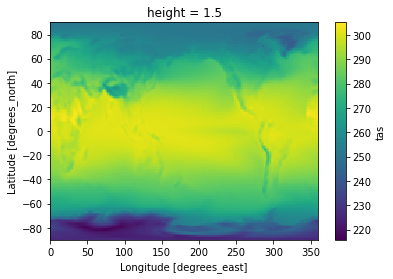

In [129]:
# We extract the data we want by specifying the: variable, experiment, and statistic we want.
data_dict['tas','historical','mean'].plot() # it'll plot as it's a data array

In [131]:
"""
Let's get the area and land area for UKESM
"""

# Use the get_fixed() function to return the gridcell area and land fraction for the model we want.
ds_area, ds_land = get_fixed('MOHC','UKESM1-0-LL','r1i1p1f2') 
# Let's define a data array for the area weight of the gridcells
da_weight = ds_area['areacella'] / ds_area['areacella'].sum()
da_weight = da_weight.rename(new_name_or_name_dict='area_weight') # we don't really need to do this but why not.
# now if we inspect the da_weight variable we'll see that it's a data array containing a variable: "area_weight"

# now for land area
da_land_area = ds_area['areacella'] * ds_land['sftlf'] * 0.01 # 0.01 is needed as land fraction is a percentage
da_land_weight = da_land_area / da_land_area.sum()
da_land_weight = da_land_weight.rename(new_name_or_name_dict='land_area_weight')

# now let's do a land mask, 
da_land_1_mask = ds_land['sftlf'] > 1 # we'll be generous and count any place with >1% land in a grid cell
da_land_50_mask = ds_land['sftlf'] > 50 # 50%
da_land_99_mask = ds_land['sftlf'] > 99 # 99%

## TO DO add +/- 66.3 mask so that Antarctic and Arctic are excluded.

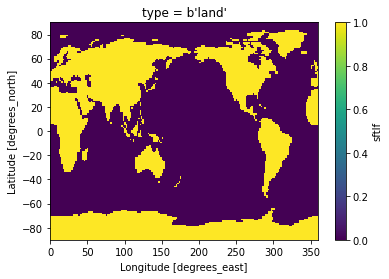

In [102]:
da_land_50_mask.plot()

The land mask looks good.

In [128]:
"""
Now, let's calculate some anomalies and store them in dictionaries so we can easily access them later.
"""

# This is our list of anomalies, 1st - 2nd:       # I'm only getting the anomalies I need for this analysis but you can extend it easily for your use.
anom_list = [('ssp585','historical'), # SSP5-8.5 - historical
             ('ssp245','ssp585'), # etc.
             ('G6sulfur','ssp585'),
             ('G6solar','ssp585'),
            ]

# First let's set up a list of empty dictionaries to store all the results
global_anom_dict, anom_data_dict, norm_anom_data_dict, SD_norm_anom_data_dict = {}, {}, {}, {} # does same thing as 4 lines of X = {}

# Now we loop through variables and our pairs of experiments to calculate our anomalies
for var in var_settings_dict.keys():
    for exp_1, exp_2 in anom_list:
        
        # First let's do a global area-weighted mean, saving a single value in the dictionary:
        global_anom_dict[(var,exp_1,exp_2)] = ((data_dict[var,exp_1,'mean'] - data_dict[var,exp_2,'mean']) * da_weight).sum().values
        # Second let's calculate the anomaly between the 2 data arrays for the experiments and variable we've specified:
        anom_data_dict[(var,exp_1,exp_2)] = data_dict[var,exp_1,'mean'] - data_dict[var,exp_2,'mean']
        # Third, let's calculate the global-mean-temperature normalized anomaly using those 2 previous calculations:
        norm_anom_data_dict[(var,exp_1,exp_2)] = anom_data_dict[(var,exp_1,exp_2)] / global_anom_dict[(var,exp_1,exp_2)]
        # Finally, let's calculate the anomalies normalized by both temperature change and control standard deviations:
        ssp585_SD_norm_anom = (ssp585_anom / hist_std) / abs(ssp585_anom_T)

{('pr', 'ssp585', 'historical'): array(3.99287451e-06),
 ('pr', 'ssp245', 'ssp585'): array(-1.09702607e-06),
 ('pr', 'G6sulfur', 'ssp585'): array(-2.56482219e-06),
 ('pr', 'G6solar', 'ssp585'): array(-2.00558424e-06),
 ('tas', 'ssp585', 'historical'): array(6.09300988),
 ('tas', 'ssp245', 'ssp585'): array(-2.13288869),
 ('tas', 'G6sulfur', 'ssp585'): array(-2.1315741),
 ('tas', 'G6solar', 'ssp585'): array(-2.19894388),
 ('sfcWind', 'ssp585', 'historical'): array(-0.07164483, dtype=float32),
 ('sfcWind', 'ssp245', 'ssp585'): array(0.02614115, dtype=float32),
 ('sfcWind', 'G6sulfur', 'ssp585'): array(-0.08806263, dtype=float32),
 ('sfcWind', 'G6solar', 'ssp585'): array(-0.01338461, dtype=float32),
 ('psl', 'ssp585', 'historical'): array(33.686874, dtype=float32),
 ('psl', 'ssp245', 'ssp585'): array(-16.591877, dtype=float32),
 ('psl', 'G6sulfur', 'ssp585'): array(-20.84934, dtype=float32),
 ('psl', 'G6solar', 'ssp585'): array(-21.049084, dtype=float32)}

In [ ]:
### Note to self, a much more elegant way to do this would be like my get_blah_data() function which either calculates then saves the data or just loads a previously saved result.

In [103]:
num_years = 90 # the t-test needs to know how long our sample is.
p_thresh = 0.05

var = 'pr'

"""
Calculate the global-mean temperature anomalies for these comparisons
"""
# Calculate the anomaly for ssp585 relative to historical:
# I've combined a lot into one line here so let's work from inside out, first I take the difference over all points, then I multiply that by the area_weight of those points
# Then I sum all weighted points to get a single global mean in a data array, then I convert that to a single-element numpy array with .values
ssp585_anom_T = ((data_dict['tas','ssp585','mean'] - data_dict['tas','historical','mean']) * da_weight).sum().values
# Calculate the anomaly of other experiments relative to ssp585, i.e. what is the effect of solar geo alone and mitigation relative to global warming.
ssp245_585_anom_T = ((data_dict['tas','ssp245','mean'] - data_dict['tas','ssp585','mean']) * da_weight).sum().values
G6sulfur_585_anom_T = ((data_dict['tas','G6sulfur','mean'] - data_dict['tas','ssp585','mean']) * da_weight).sum().values
G6solar_585_anom_T = ((data_dict['tas','G6solar','mean'] - data_dict['tas','ssp585','mean']) * da_weight).sum().values

"""
Calculate the anomalies for our variable
"""
# Calculate the anomaly for ssp585 relative to historical:
ssp585_anom = data_dict[var,'ssp585','mean'] - data_dict[var,'historical','mean']
# Calculate the anomaly of other experiments relative to ssp585, i.e. what is the effect of solar geo alone and mitigation relative to global warming.
ssp245_585_anom = data_dict[var,'ssp245','mean'] - data_dict[var,'ssp585','mean']
G6sulfur_585_anom = data_dict[var,'G6sulfur','mean'] - data_dict[var,'ssp585','mean']
G6solar_585_anom = data_dict[var,'G6solar','mean'] - data_dict[var,'ssp585','mean']

"""
global-mean-temperature Normalized anomalies, i.e. change per degree celcius cooling/warming.
"""

ssp585_norm_anom = ssp585_anom / ssp585_anom_T
ssp245_585_norm_anom = ssp245_585_anom / ssp245_585_anom_T
G6sulfur_585_norm_anom = G6sulfur_585_anom / G6sulfur_585_anom_T
G6solar_585_norm_anom = G6solar_585_anom / G6solar_585_anom_T

"""
global-mean-temperature Normalized anomalies in terms of historical standard deviations
"""

hist_std = data_dict[var,'historical','std']

# divide anomaly by historical standard deviation then divide by absolute global-mean temperature change
ssp585_SD_norm_anom = (ssp585_anom / hist_std) / abs(ssp585_anom_T)
ssp245_585_SD_norm_anom = (ssp245_585_anom / hist_std) / abs(ssp245_585_anom_T)
G6sulfur_585_SD_norm_anom = (G6sulfur_585_anom / hist_std) / abs(G6sulfur_585_anom_T)
G6solar_585_SD_norm_anom = (G6solar_585_anom / hist_std) / abs(G6solar_585_anom_T)


#### OK, that's a little clunky, I'll come back later and wrap it up in a few loops and save the data into a new dictionary to make it more compact + sensible.

In [104]:
ssp585_anom_T, ssp245_585_anom_T, G6sulfur_585_anom_T, G6solar_585_anom_T

(array(6.09300988), array(-2.13288869), array(-2.1315741), array(-2.19894388))

## Those global-mean temperature responses look right
ssp5-8.5 is a huge amount of forcing and UKESM is highly sensitive so 6 C is high but right for this model.
the others show approximately the same cooling so that's right too.

In [105]:
"""
Let's set up our data - we're using the anomalies measured in control standard deviations, normalized by global-mean temperature
"""

# Let's rename these to something generic so it'll be easier to turn this into a generalizable function.
GW_array = ssp585_SD_norm_anom
SG_array = -1. * G6sulfur_585_SD_norm_anom # Now it has the same sign as ssp585 anomaly

# Global-mean temperature anomalies
GW_T = ssp585_anom_T
SG_T = G6sulfur_585_anom_T

# First we "flatten" the data arrays, pancaking the data into a single dimension as some functions need to read it this way. 
# This happens in the same way for every array so despite losing 1 dimension,
# Every value in position N in every array will still refer to the same point.
GW_flat = GW_array.values.flatten()
SG_flat = SG_array.values.flatten()
eff_flat = SG_flat / GW_flat

# Let's do the weights and masks too.
area_weight = da_weight.values.flatten()
land_weight = da_land_weight.values.flatten()
land_50_mask = da_land_50_mask.values.flatten()

In [106]:
"""
Find the threhold level of T-test passing in standard deviations
"""
num_steps = 1000

ttest_sds = None
for IDX in [idx / num_steps for idx in range(num_steps)]:
    if ttest_sds is None:
        if ttest_sub(IDX, 1, num_years, 0, 1, num_years, equal_var=True) < p_thresh:
            ttest_sds = IDX
"""
Normalize threshold by change in temperature under solar geo so test applies to normalized data.
"""        
ttest_sds_orig = ttest_sds / abs(SG_T)
ttest_sds_orig

0.1388645136050009

In [107]:
"""
Sort the global warming anomaly from most negative (or smallest) to most positive, and bin it into 100 percentiles (pctl) or 1000 milltiles (mltls),
and then bin the solar geo and efficacy data using these global warming bins.

All the solar geo and efficacy data for the same percentile of the global warming anomaly are now together.
This allows us to analyse these metrics as a function of the global warming percentiles.
"""

# Now, let's define the percentile and milltile (1000) bounds and centres
# 0-1 in 1%
percentile_bounds = [(idx+1) / 100. for idx in range(99)] # 1 - 99
percentile_centres = [(idx+0.5) / 100. for idx in range(100)] # 0.5 - 99.5

# 0-1 in 0.1%
milltile_bounds = [(idx+1) / 1000. for idx in range(999)] # 1 - 999
milltile_centres = [(idx+0.5) / 1000. for idx in range(1000)] # 0.5 - 999.5

# XXX_pctl_data = a list of 100 arrays with all data points that fall in each percentile of global warming anomaly.
GW_pctl_data, GW_pctl_frac = sort_data_distribution(GW_flat, GW_flat, percentile_bounds, distribution=True)
SG_pctl_data, SG_pctl_frac = sort_data_distribution(SG_flat, GW_flat, percentile_bounds, distribution=True)
eff_pctl_data, eff_pctl_frac = sort_data_distribution(eff_flat, GW_flat, percentile_bounds, distribution=True)

# XXX_mltl_data as above for 1000 milltiles.
GW_mltl_data, GW_mltl_frac = sort_data_distribution(GW_flat, GW_flat, milltile_bounds, distribution=True)
SG_mltl_data, SG_mltl_frac = sort_data_distribution(SG_flat, GW_flat, milltile_bounds, distribution=True)
eff_mltl_data, eff_mltl_frac = sort_data_distribution(eff_flat, GW_flat, milltile_bounds, distribution=True)

In [108]:
"""
Now we stick the percentile chunks back together in percentile order.

NOTE - The data is sorted into percentiles / milltiles but does not perfectly match, 
i.e. individual gridpoints no longer have perfectly matching indices in these arrays.
This is OK for plotting at the percentile / milltile level but not for point-wise calculations. 
"""
GW_pctl_data_concat = np.concatenate(GW_pctl_data)
SG_pctl_data_concat = np.concatenate(SG_pctl_data)
eff_pctl_data_concat = np.concatenate(eff_pctl_data)

GW_mltl_data_concat = np.concatenate(GW_mltl_data)
SG_mltl_data_concat = np.concatenate(SG_mltl_data)
eff_mltl_data_concat = np.concatenate(eff_mltl_data)

# Now we create an array where the values for each point show which percentile it belongs too.
mltls_for_data_concat = np.concatenate([milltile_centres[IDX] * np.ones_like(GW_mltl_data[IDX]) for IDX in range(len(milltile_centres))])
pctls_for_data_concat = np.concatenate([percentile_centres[IDX] * np.ones_like(GW_pctl_data[IDX]) for IDX in range(len(percentile_centres))])

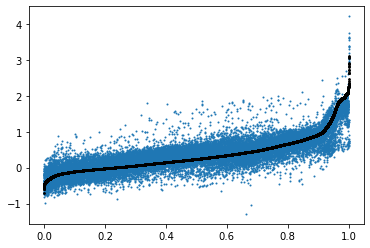

In [109]:
"""
Let's test that our data has been sorted, plotting all anomalies sorted by GW milltiles
"""
plt.scatter(mltls_for_data_concat, SG_mltl_data_concat, s=1)
plt.scatter(mltls_for_data_concat, GW_mltl_data_concat, color='k', s=3)

#### Great, the black line shows that the GW results are sorted from smallest to largest, whereas the blue dots show the range of SG results as a function of the GW data.

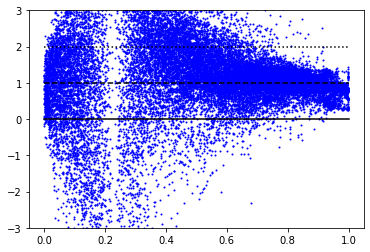

In [110]:
plt.scatter(mltls_for_data_concat, eff_mltl_data_concat, color='b', s=1)
plt.ylim(-3,3)
plt.plot([0,1],[0,0], color='k')
plt.plot([0,1],[1,1], color='k', linestyle='dashed')
plt.plot([0,1],[2,2], color='k', linestyle='dotted')

In [111]:
# sort_data_distribution(GW_flat, GW_flat, percentile_bounds, distribution=True)

plot_pctl_bounds = [0.05,0.25,0.5,0.75,0.95]

GW_pctl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in GW_pctl_data]
SG_pctl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in SG_pctl_data]
eff_pctl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in eff_pctl_data]

GW_mltl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in GW_mltl_data]
SG_mltl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in SG_mltl_data]
eff_mltl_data_plot_pctls = [weighted_quantile(IDX, plot_pctl_bounds) for IDX in eff_mltl_data]

In [112]:
def find_first_value(sorted_data, value):
    # Finds the first occurence of a given value for data sorted from low to high
    sign = np.sign(sorted_data - value)
    signchange = ((np.roll(sign, 1) - sign) != 0).astype(int)
    sign_where = np.where(signchange == 1)
    return sign_where[0][1]

# Find the medians for the global warming milltiles
GW_mltl_data_medians = np.array([np.median(IDX) for IDX in GW_mltl_data])

# Find the first milltile where the anomaly exceeds zero plus or minus the t-test threshold.
zero_pctl = milltile_centres[find_first_value(GW_mltl_data_medians, 0)]
ttest_neg_pctl = milltile_centres[find_first_value(GW_mltl_data_medians, -1.*ttest_sds_orig)]
ttest_pos_pctl = milltile_centres[find_first_value(GW_mltl_data_medians, ttest_sds_orig)]

Text(0, 0.5, 'G6sulfur and SSP5-8.5 Normalized SD Anomalies')

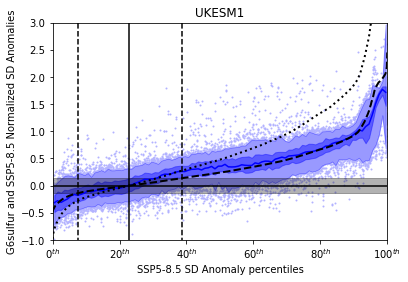

In [117]:
plt.scatter(mltls_for_data_concat, SG_mltl_data_concat, s=1, color=(0.7, 0.7, 1.0))

plot_5th = np.array([INNER[0] for INNER in SG_pctl_data_plot_pctls])
plot_95th = np.array([INNER[4] for INNER in SG_pctl_data_plot_pctls])
plt.fill_between(percentile_centres, plot_5th, plot_95th, color='w')
plt.fill_between(percentile_centres, plot_5th, plot_95th, color='b', alpha=0.4)

plot_25th = np.array([INNER[1] for INNER in SG_pctl_data_plot_pctls])
plot_75th = np.array([INNER[3] for INNER in SG_pctl_data_plot_pctls])
plt.fill_between(percentile_centres, plot_25th, plot_75th, color='b', alpha=0.4)

plot_50th = np.array([INNER[2] for INNER in SG_pctl_data_plot_pctls])
plt.plot(percentile_centres, plot_50th, color='b')

plt.plot(milltile_centres, GW_mltl_data_medians, color='k', linewidth=2, linestyle='dashed')
plt.plot(milltile_centres, 2.* GW_mltl_data_medians, color='k', linewidth=2, linestyle='dotted')
plt.plot([0,1],[0,0],color='k')
plt.plot([zero_pctl, zero_pctl],[-100,100],color='k')
plt.plot([ttest_neg_pctl, ttest_neg_pctl],[-100,100],color='k', linestyle='dashed')
plt.plot([ttest_pos_pctl, ttest_pos_pctl],[-100,100],color='k', linestyle='dashed')

plt.fill_between([0,1],[-1.*ttest_sds_orig, -1.*ttest_sds_orig],[ttest_sds_orig, ttest_sds_orig],color='k',alpha=0.3)
# plt.plot([0,1],[-1.*ttest_sds_orig, -1.*ttest_sds_orig],color='k', linestyle='dashed')
# plt.plot([0,1],[ttest_sds_orig, ttest_sds_orig],color='k', linestyle='dashed')

plt.xlim([0,1])
plt.ylim([-1,3])

plt.xticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=['0$^{th}$', '20$^{th}$', '40$^{th}$', '60$^{th}$', '80$^{th}$', '100$^{th}$'])

plt.title('UKESM1')
plt.xlabel('SSP5-8.5 SD Anomaly percentiles')
plt.ylabel('G6sulfur and SSP5-8.5 Normalized SD Anomalies')

Text(0.5, 1.0, 'UKESM1 Efficacy')

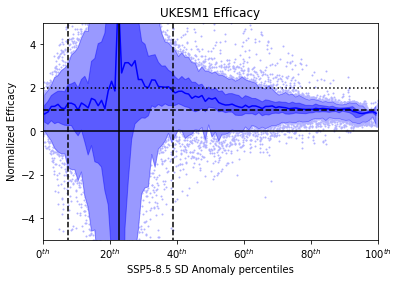

In [118]:
plt.scatter(mltls_for_data_concat, eff_mltl_data_concat, s=1, color=(0.7, 0.7, 1.0))

plot_5th = np.array([INNER[0] for INNER in eff_pctl_data_plot_pctls])
plot_95th = np.array([INNER[4] for INNER in eff_pctl_data_plot_pctls])
plt.fill_between(percentile_centres, plot_5th, plot_95th, color='w')
plt.fill_between(percentile_centres, plot_5th, plot_95th, color='b', alpha=0.4)

plot_25th = np.array([INNER[1] for INNER in eff_pctl_data_plot_pctls])
plot_75th = np.array([INNER[3] for INNER in eff_pctl_data_plot_pctls])
plt.fill_between(percentile_centres, plot_25th, plot_75th, color='b', alpha=0.4)

plot_50th = np.array([INNER[2] for INNER in eff_pctl_data_plot_pctls])
plt.plot(percentile_centres, plot_50th, color='b')

plt.plot([0,1],[0,0],color='k')
plt.plot([zero_pctl, zero_pctl],[-100,100],color='k')
plt.plot([ttest_neg_pctl, ttest_neg_pctl],[-100,100],color='k', linestyle='dashed')
plt.plot([ttest_pos_pctl, ttest_pos_pctl],[-100,100],color='k', linestyle='dashed')

# Efficacy of 1, 2 lines:
plt.plot([0,1],[1,1], color='k', linestyle='dashed')
plt.plot([0,1],[2,2], color='k', linestyle='dotted')

# set plot limits
plt.xlim([0,1])
plt.ylim([-5,5])

# set x-axis labels
plt.xticks(ticks=[0,0.2,0.4,0.6,0.8,1.0], labels=['0$^{th}$', '20$^{th}$', '40$^{th}$', '60$^{th}$', '80$^{th}$', '100$^{th}$'])

# label X and Y axes
plt.xlabel('SSP5-8.5 SD Anomaly percentiles')
plt.ylabel('Normalized Efficacy')
plt.title('UKESM1 Efficacy')